In [1]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib import verbose
#verbose.level = 'helpful'      # one of silent, helpful, debug, debug-annoying

# taken from https://github.com/jrmontag/STLDecompose
# requires installation - pip install stldecompose
from stldecompose import decompose
# Simpler smoothing uses:
# from statsmodels.tsa.seasonal import seasonal_decompose

import geopandas as gpd

C:\Users\ajwalker\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Overall prescribing

## Import data

In [279]:
q = '''
SELECT
  p.practice,
  pct,
  p.month,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050113',items,0)) AS uti_items,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050103',items,0)) AS tetracyclines,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050108',items,0)) AS sulphonamides_trimethoprim,
  SUM(IF(SUBSTR(p.bnf_code,1,9)='0501013K0',items,0)) AS coamoxiclav,
  SUM(IF(SUBSTR(p.bnf_code,1,7)='0501021',items,0)) AS cephalosporins,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050112',items,0)) AS quinolones,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050105',items,0)) AS macrolides,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050111',items,0)) AS metroni_tini_ornidazole,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050101',items,0)) AS penicillins,
  SUM(IF(SUBSTR(p.bnf_code,1,9)='0501013K0' OR
         SUBSTR(p.bnf_code,1,7)='0501021' OR
         SUBSTR(p.bnf_code,1,6)='050112',items,0)) AS all_broad_spectrum,
  SUM(IF(SUBSTR(p.bnf_code,1,9)='0501013K0' OR
         SUBSTR(p.bnf_code,1,7)='0501021' OR
         SUBSTR(p.bnf_code,1,6) IN ('050112','050113','050103','050105','050111','050101'),items,0)) AS denom_broad_spectrum,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050110',items,0)) AS antileprotic,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050109',items,0)) AS antituberculosis,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050107',items,0)) AS some_other_antibacterials,
  SUM(IF(SUBSTR(p.bnf_code,1,6)='050104',items,0)) AS aminogylcosides,
  SUM(IF(SUBSTR(p.bnf_code,1,9) IN ('0501013C0','0501013F0','0501013E0','0501013B0'),items,0)) AS amoxicillin,
  SUM(items) AS items,
  SUM(IF((p.bnf_code like'0501130R0%AG' OR p.bnf_code like '0501130R0%AA' OR p.bnf_code like '0501130R0%AD' 
    OR p.bnf_code LIKE '0501015P0%AB' OR p.bnf_code LIKE '0501080W0%AE'), p.quantity,0) 
    * r.percent_of_adq) AS numerator_uti_course,
   SUM(IF((p.bnf_code like '0501130R0%AG' OR p.bnf_code like '0501130R0%AA' OR p.bnf_code like '0501130R0%AD'
    OR p.bnf_code like '0501015P0%AB' OR p.bnf_code LIKE '0501080W0%AE'), p.items,0)) AS denominator_uti_course,
  AVG(total_list_size) AS list_size,
  CAST(JSON_EXTRACT(MAX(star_pu), '$.oral_antibacterials_item') AS FLOAT64) AS star_pu_items,
FROM
  ebmdatalab.alex.antibiotic_prescribing p
INNER JOIN
  ebmdatalab.hscic.practices prac
ON
  p.practice = prac.code
  AND prac.setting = 4
LEFT JOIN
  ebmdatalab.alex.practice_statistics_all_years_really stat
ON
  p.practice = stat.practice
  AND p.month = stat.month
LEFT JOIN
  ebmdatalab.hscic.presentation r
ON
  p.bnf_code = r.bnf_code
GROUP BY
  practice,
  pct,
  month
ORDER BY
  practice,
  month
'''

all_antibiotics = pd.read_gbq(q, GBQ_PROJECT_ID, verbose=False, dialect='standard')
all_antibiotics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698489 entries, 0 to 698488
Data columns (total 26 columns):
practice                      698489 non-null object
pct                           698489 non-null object
month                         698489 non-null datetime64[ns]
uti_items                     698489 non-null int32
tetracyclines                 698489 non-null int32
sulphonamides_trimethoprim    698489 non-null int32
coamoxiclav                   698489 non-null int32
cephalosporins                698489 non-null int32
quinolones                    698489 non-null int32
macrolides                    698489 non-null int32
metroni_tini_ornidazole       698489 non-null int32
penicillins                   698489 non-null int32
all_broad_spectrum            698489 non-null int32
denom_broad_spectrum          698489 non-null int32
antileprotic                  698489 non-null int32
antituberculosis              698489 non-null int32
some_other_antibacterials     698489 non-null 

In [394]:
pc = all_antibiotics.copy()

pc["percent_broad_spec"] = (pc.all_broad_spectrum/pc.denom_broad_spectrum).fillna(0)
# deal with nulls
pc["three_day_courses"] = (pc.numerator_uti_course/pc.denominator_uti_course).fillna(0)
pc = pc.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course"],axis=1)

for column in pc:
    if (pc[column].dtype == np.float64) | (pc[column].dtype == np.int32):
        pc["%s_per_thousand"%column] = pc[column]/(pc["list_size"]/1000)
    else:
        pc[column] = pc[column]
pc["items_per_starpu"] = pc["items"]/pc["star_pu_items"]
        
pc = pc.drop(["star_pu_items_per_thousand","percent_broad_spec_per_thousand","three_day_courses_per_thousand","list_size_per_thousand"],axis=1)
pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698489 entries, 0 to 698488
Data columns (total 42 columns):
practice                                   698489 non-null object
pct                                        698489 non-null object
month                                      698489 non-null datetime64[ns]
uti_items                                  698489 non-null int32
tetracyclines                              698489 non-null int32
sulphonamides_trimethoprim                 698489 non-null int32
coamoxiclav                                698489 non-null int32
cephalosporins                             698489 non-null int32
quinolones                                 698489 non-null int32
macrolides                                 698489 non-null int32
metroni_tini_ornidazole                    698489 non-null int32
penicillins                                698489 non-null int32
antileprotic                               698489 non-null int32
antituberculosis                 

In [395]:
pc.practice.drop_duplicates().count()

8173

### Calculations and percentiles

In [396]:
# filter for normal practices
filtered = pc.copy().loc[(pc.list_size>1000) & (~pd.isnull(pc.star_pu_items)) & (pc["month"]>"2010-09-01") ]
filtered.head()

x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))
pcf = filtered.groupby('month').quantile(x)
pcf = pcf.reset_index().rename(columns={"level_1": 'percentile'})
pcf.head(20)

,month,percentile,actual_cost,actual_cost_per_thousand,aminogylcosides,aminogylcosides_per_thousand,amoxicillin,amoxicillin_per_thousand,antileprotic,antileprotic_per_thousand,...,star_pu_cost,star_pu_cost_per_thousand,star_pu_items,sulphonamides_trimethoprim,sulphonamides_trimethoprim_per_thousand,tetracyclines,tetracyclines_per_thousand,three_day_courses,uti_items,uti_items_per_thousand
0,2010-10-01,0.10,402.2550,130.151884,0.0,0.0,38.0,9.722523,0.0,0.000000,...,5299.759800,2078.112163,1285.021141,8.0,2.395497,7.0,2.008960,4.863636,1.0,0.326371
1,2010-10-01,0.20,595.5100,155.463319,0.0,0.0,54.0,11.820060,0.0,0.000000,...,7136.613661,2155.472834,1741.449384,13.0,3.302912,12.0,2.772643,5.367647,3.0,0.628634
2,2010-10-01,0.30,793.1550,173.112510,0.0,0.0,68.0,13.374040,0.0,0.000000,...,9126.167715,2210.709634,2227.098062,18.0,4.010169,16.0,3.430532,5.709112,5.0,0.927650
3,2010-10-01,0.40,1029.0300,188.231589,0.0,0.0,83.0,14.779781,0.0,0.000000,...,11419.922196,2251.251425,2781.836536,24.0,4.576160,22.0,4.024497,6.023256,7.0,1.225302
4,2010-10-01,0.50,1283.4700,203.303393,0.0,0.0,99.0,16.226702,0.0,0.000000,...,13857.118965,2284.138971,3393.865396,31.0,5.122884,28.0,4.630395,6.333333,9.0,1.534527
5,2010-10-01,0.60,1551.9300,219.782798,0.0,0.0,118.0,17.764899,0.0,0.000000,...,16604.063721,2314.556077,4050.610752,37.0,5.633479,35.0,5.232558,6.633929,12.0,1.861567
6,2010-10-01,0.70,1879.3200,238.540582,0.0,0.0,141.0,19.792323,0.0,0.000000,...,19672.363108,2343.895725,4799.792600,47.0,6.203772,43.0,5.935819,7.000000,16.0,2.251428
7,2010-10-01,0.80,2281.8600,262.040474,0.0,0.0,169.0,22.669650,0.0,0.000000,...,23416.641641,2380.441956,5735.567645,57.0,6.887915,55.0,6.920415,7.394928,21.0,2.726653
8,2010-10-01,0.90,2927.3450,302.851177,0.0,0.0,212.0,27.275825,1.0,0.149039,...,28639.309920,2434.498435,7006.119633,74.0,7.901743,73.0,8.425655,8.154009,30.0,3.526374
9,2010-10-01,0.01,168.7480,76.323880,0.0,0.0,14.0,5.073234,0.0,0.000000,...,3060.805769,1909.087439,743.201644,2.0,0.634660,1.0,0.552686,3.461538,0.0,0.000000


In [397]:
filtered.practice.drop_duplicates().count()

8052

## Practice level plots

### Without smoothing

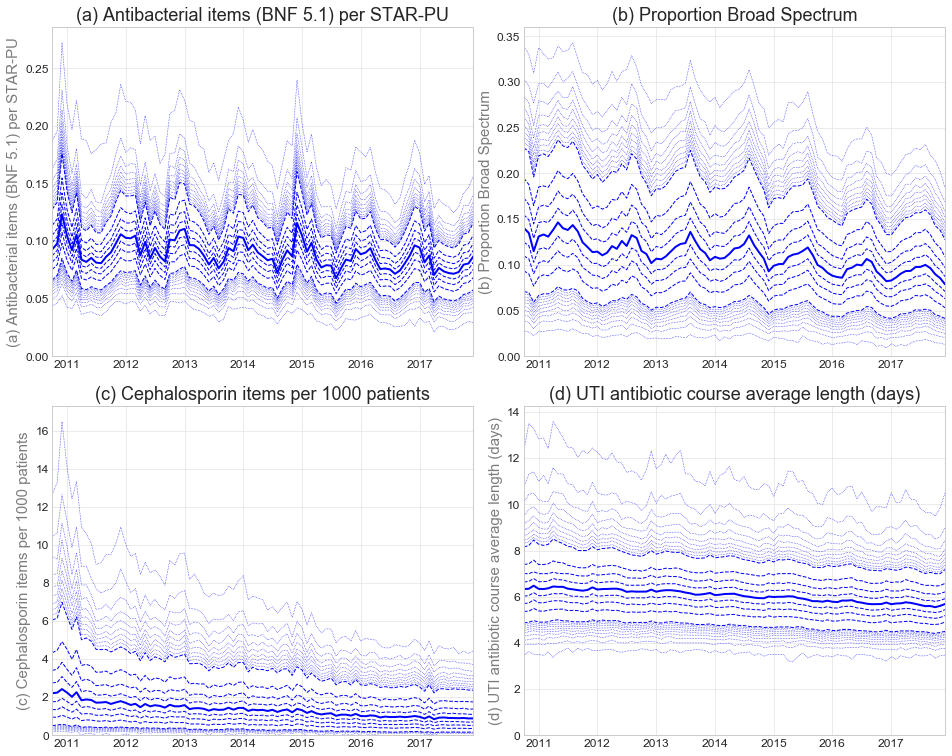

In [398]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Proportion Broad Spectrum'),
     (2,'cephalosporins_per_thousand',1,0,'(c) Cephalosporin items per 1000 patients'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)')]
x = pd.Series(x)

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    #if  i[3]%2==0:    # set y axis title only for charts in leftmost column
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_no_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

### WIth smoothing

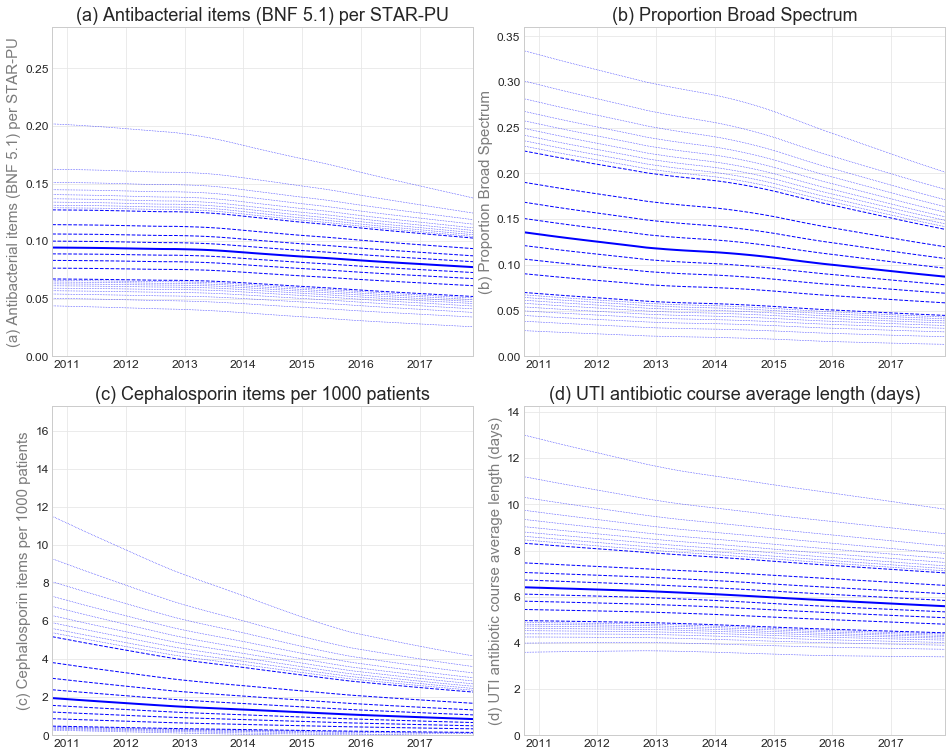

In [399]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Proportion Broad Spectrum'),
     (2,'cephalosporins_per_thousand',1,0,'(c) Cephalosporin items per 1000 patients'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)')]
x = pd.Series(x)

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        #data.info()
        # for smoothing, dataframe needs to be non-missing and have a DateTime index
        #data = data.dropna()
        data = data.set_index('month')
        res = data[[i[1]]]
        #res = seasonal_decompose(res, model='additive') # cruder smoothing
        res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        res = res.trend
        
        if decile == .5:
            ax.plot(data["dates"],res,'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],res,'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],res,'b--',linewidth=1)
    #if  i[3]%2==0:    # set y axis title only for charts in leftmost column
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('practice_deciles_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

## CCG level

In [400]:
# remove practices with no STAR-PU
pc_ccg =  all_antibiotics.copy().loc[~pd.isnull(all_antibiotics.star_pu_items) & (all_antibiotics["month"]>"2010-09-01") ]
# group to CCGs
pc_ccg = pc_ccg.groupby(['pct','month'],as_index=False).sum()

pc_ccg["percent_broad_spec"] = (pc_ccg.all_broad_spectrum/pc_ccg.denom_broad_spectrum).fillna(0)
# deal with nulls
pc_ccg["three_day_courses"] = (pc_ccg.numerator_uti_course/pc_ccg.denominator_uti_course).fillna(0)
pc_ccg = pc_ccg.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course"],axis=1)

for column in pc_ccg:
    if (pc_ccg[column].dtype == np.float64) | (pc_ccg[column].dtype == np.int32):
        pc_ccg["%s_per_thousand"%column] = pc_ccg[column]/(pc["list_size"]/1000)
    else:
        pc_ccg[column] = pc_ccg[column]
pc_ccg["items_per_starpu"] = pc_ccg["items"]/pc_ccg["star_pu_items"]

pc_ccg = pc_ccg.groupby('month').quantile(x)
pc_ccg = pc_ccg.reset_index().rename(columns={"level_1": 'percentile'})

pc_ccg.head(9)

,month,percentile,actual_cost,actual_cost_per_thousand,aminogylcosides,aminogylcosides_per_thousand,amoxicillin,amoxicillin_per_thousand,antileprotic,antileprotic_per_thousand,...,star_pu_items,star_pu_items_per_thousand,sulphonamides_trimethoprim,sulphonamides_trimethoprim_per_thousand,tetracyclines,tetracyclines_per_thousand,three_day_courses,three_day_courses_per_thousand,uti_items,uti_items_per_thousand
0,2010-10-01,0.1,1591.278,1300.477421,0.0,0.000000,137.2,88.967573,0.0,0.043300,...,3121.090068,2728.617589,38.0,25.591926,39.2,33.545253,5.642266,0.733800,10.9,7.863933
1,2010-10-01,0.2,27428.062,4773.310251,0.0,0.000000,2183.6,351.417726,3.0,0.644653,...,70507.214552,12407.329711,640.8,114.687775,600.4,109.527456,5.972369,0.902188,184.8,37.263790
2,2010-10-01,0.3,35292.229,7292.125651,1.0,0.206847,2638.7,515.179612,5.0,0.940618,...,92192.588198,18310.678872,835.0,181.656947,711.0,165.931423,6.148594,1.176669,239.5,56.363661
3,2010-10-01,0.4,42312.710,10493.478660,1.0,0.372024,3076.8,816.434509,7.0,1.586271,...,107201.957923,24629.145208,933.6,231.217369,844.8,212.657456,6.280731,1.523314,297.8,75.154115
4,2010-10-01,0.5,48229.270,12549.477032,2.0,0.631313,3663.0,975.971034,9.0,2.199978,...,119229.344369,32963.078720,1105.5,305.776173,987.5,288.020391,6.417230,1.855103,349.5,98.499062
5,2010-10-01,0.6,53418.376,17269.614564,3.0,0.862069,4340.6,1308.450802,10.0,2.926886,...,136326.700801,41958.124907,1226.8,370.364910,1127.4,361.474163,6.522719,2.251203,424.2,127.883799
6,2010-10-01,0.7,61159.227,22553.293443,4.0,1.219512,4945.5,1718.470137,11.1,4.064482,...,154394.486686,56406.160788,1503.8,542.244305,1357.4,532.204625,6.636703,2.712424,524.1,183.920997
7,2010-10-01,0.8,69447.044,33772.272297,5.0,1.876173,5526.4,2589.065683,15.0,6.457498,...,178267.333735,84062.476366,1788.2,909.336285,1778.2,783.407358,6.758487,3.451170,645.0,295.380538
8,2010-10-01,0.9,89203.479,64267.440631,8.0,4.081633,6808.0,4480.515185,19.7,12.739247,...,232987.761724,151246.584298,2330.6,1498.262006,2347.6,1628.879111,7.032700,6.053053,931.8,581.241289


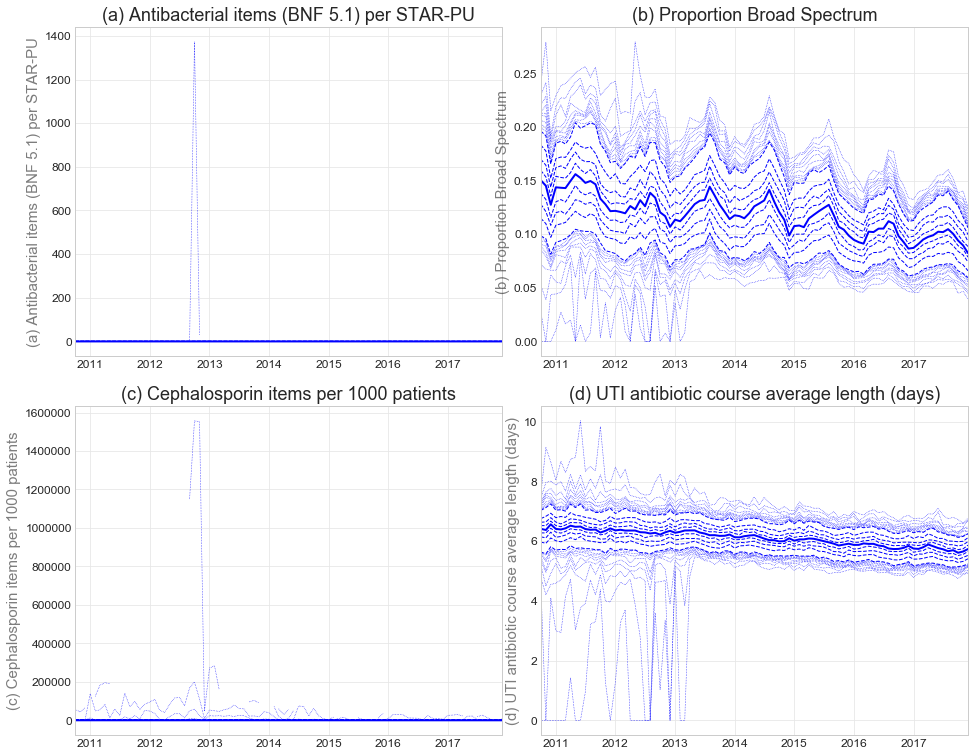

In [401]:
dfp = pc_ccg.sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]
x = pd.Series(x)

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Proportion Broad Spectrum'),
     (2,'cephalosporins_per_thousand',1,0,'(c) Cephalosporin items per 1000 patients'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)')]

fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    #ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.09,hspace = 0.15)
#plt.savefig('ccg_deciles.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

# MAPS

In [402]:
#aggregate over last year
ccg_last_year =  all_antibiotics.copy().loc[~pd.isnull(all_antibiotics.star_pu_items) & (all_antibiotics["month"] >'2016-12-01') ]

#ccg_last_year = all_antibiotics_ccg.loc[all_antibiotics_ccg.month]
ccg_last_year = ccg_last_year.groupby('pct').sum()
ccg_last_year["star_pu_items"] = ccg_last_year["star_pu_items"]/12
ccg_last_year["list_size"] = ccg_last_year["list_size"]/12

ccg_last_year["percent_broad_spec"] = (ccg_last_year.all_broad_spectrum/ccg_last_year.denom_broad_spectrum).fillna(0)
# deal with nulls
ccg_last_year["three_day_courses"] = (ccg_last_year.numerator_uti_course/ccg_last_year.denominator_uti_course).fillna(0)
ccg_last_year = ccg_last_year.drop(["all_broad_spectrum","denom_broad_spectrum","numerator_uti_course","denominator_uti_course"],axis=1)

for column in ccg_last_year:
    if (ccg_last_year[column].dtype == np.float64) | (ccg_last_year[column].dtype == np.int32):
        ccg_last_year["%s_per_thousand"%column] = ccg_last_year[column]/(ccg_last_year["list_size"]/1000)
    else:
        ccg_last_year[column] = ccg_last_year[column]
ccg_last_year["items_per_starpu"] = ccg_last_year["items"]/ccg_last_year["star_pu_items"]

ccg_last_year = ccg_last_year.drop(["star_pu_items_per_thousand","percent_broad_spec_per_thousand","three_day_courses_per_thousand","list_size_per_thousand"],axis=1)

ccg_last_year.head()

,uti_items,tetracyclines,sulphonamides_trimethoprim,coamoxiclav,cephalosporins,quinolones,macrolides,metroni_tini_ornidazole,penicillins,antileprotic,...,penicillins_per_thousand,antileprotic_per_thousand,antituberculosis_per_thousand,some_other_antibacterials_per_thousand,aminogylcosides_per_thousand,amoxicillin_per_thousand,items_per_thousand,actual_cost_per_thousand,star_pu_cost_per_thousand,items_per_starpu
pct,,,,,,,,,,,,,,,,,,,,,
00C,6697,9864,6081,1343,1544,1238,9725,1147,27268,60,...,252.662595,0.555954,0.185318,4.401303,0.055595,144.798239,594.852329,2839.527007,28276.676995,1.033214
00D,24004,32867,14716,3497,3893,2601,25565,4246,88248,340,...,303.015979,1.167453,0.374272,4.789993,0.051505,166.217903,680.663136,3348.125865,28525.126934,1.172898
00J,17170,27723,13384,3747,3871,2418,17354,2946,74381,231,...,289.529135,0.899171,0.326971,4.931816,0.089528,154.326530,626.951772,3254.137380,28272.214447,1.093240
00K,16607,27896,16922,4034,6188,2555,21468,4132,87080,139,...,293.755916,0.468903,0.445289,2.722336,0.026987,159.288707,622.419804,3153.426812,27961.067290,1.096456
00L,25305,40016,19128,8336,4080,2374,25575,2696,94218,373,...,293.616846,1.162401,0.891278,4.384713,0.183865,153.128393,672.537709,3127.558036,29386.295424,1.122583


In [403]:
# join to geographical data
map_data = ccg_last_year.reset_index()
names = pd.read_csv('ccg_for_map.csv')
names = names.rename(columns={"CCG17CDH":"code","CCG17NM":"name"})
map_data = map_data.merge(names[['code','name']],left_on="pct",right_on="code")
map_data['name'] = map_data['name'].str.upper()
map_data['name'] = map_data["name"].str.replace("&","AND")
map_data = map_data.set_index('name')
#map_data = map_data.round(0)
map_data.head() # 207 rows

,pct,uti_items,tetracyclines,sulphonamides_trimethoprim,coamoxiclav,cephalosporins,quinolones,macrolides,metroni_tini_ornidazole,penicillins,...,antileprotic_per_thousand,antituberculosis_per_thousand,some_other_antibacterials_per_thousand,aminogylcosides_per_thousand,amoxicillin_per_thousand,items_per_thousand,actual_cost_per_thousand,star_pu_cost_per_thousand,items_per_starpu,code
name,,,,,,,,,,,,,,,,,,,,,
NHS DARLINGTON CCG,00C,6697,9864,6081,1343,1544,1238,9725,1147,27268,...,0.555954,0.185318,4.401303,0.055595,144.798239,594.852329,2839.527007,28276.676995,1.033214,00C
"NHS DURHAM DALES, EASINGTON AND SEDGEFIELD CCG",00D,24004,32867,14716,3497,3893,2601,25565,4246,88248,...,1.167453,0.374272,4.789993,0.051505,166.217903,680.663136,3348.125865,28525.126934,1.172898,00D
NHS NORTH DURHAM CCG,00J,17170,27723,13384,3747,3871,2418,17354,2946,74381,...,0.899171,0.326971,4.931816,0.089528,154.326530,626.951772,3254.137380,28272.214447,1.093240,00J
NHS HARTLEPOOL AND STOCKTON-ON-TEES CCG,00K,16607,27896,16922,4034,6188,2555,21468,4132,87080,...,0.468903,0.445289,2.722336,0.026987,159.288707,622.419804,3153.426812,27961.067290,1.096456,00K
NHS NORTHUMBERLAND CCG,00L,25305,40016,19128,8336,4080,2374,25575,2696,94218,...,1.162401,0.891278,4.384713,0.183865,153.128393,672.537709,3127.558036,29386.295424,1.122583,00L


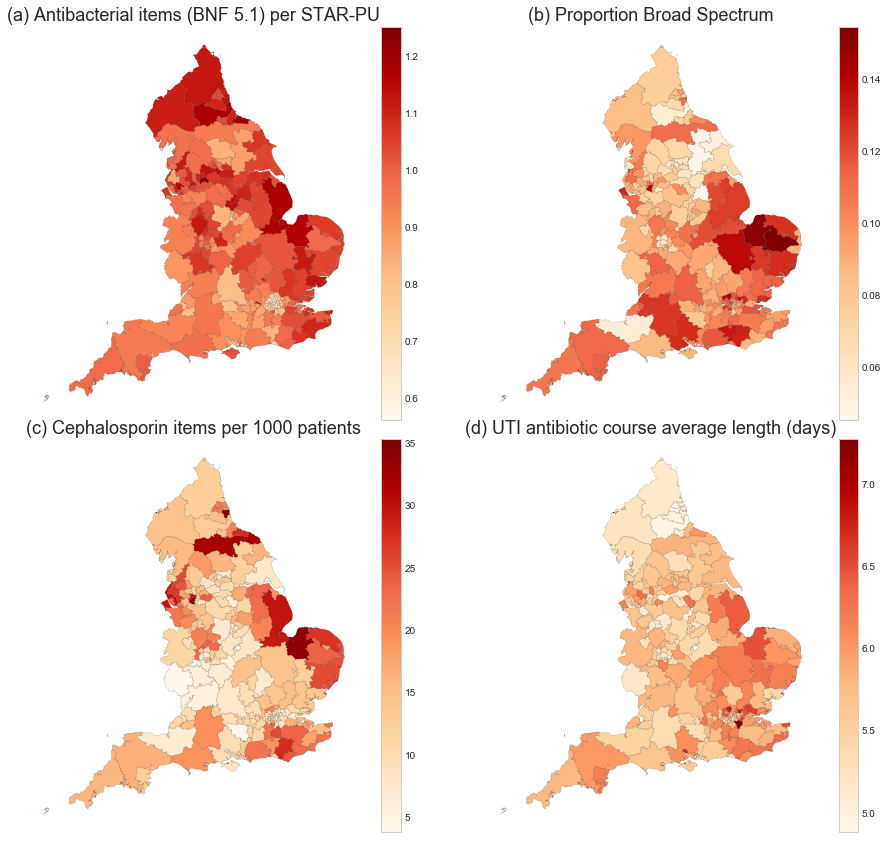

In [404]:
# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf = ccgs.join(map_data)

# set sort order of measures manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'(a) Antibacterial items (BNF 5.1) per STAR-PU'), 
     (1,'percent_broad_spec',0,1,'(b) Proportion Broad Spectrum'),
     (2,'cephalosporins_per_thousand',1,0,'(c) Cephalosporin items per 1000 patients'),
     (3,'three_day_courses',1,1, '(d) UTI antibiotic course average length (days)')]

fig = plt.figure(figsize=(16,30))
gs = gridspec.GridSpec(4,2)  # grid layout for subplots

for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='OrRd')
    ax.set_aspect(1.63)
    ax.set_title(i[4],size = 18)
    plt.axis('off')

plt.subplots_adjust(wspace = 0.05,hspace = 0.05)
plt.savefig('maps.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

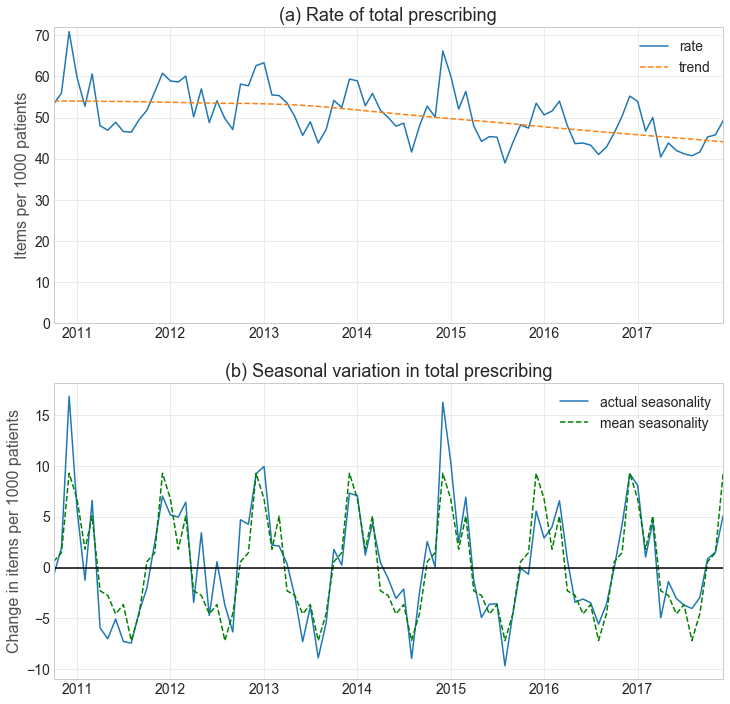

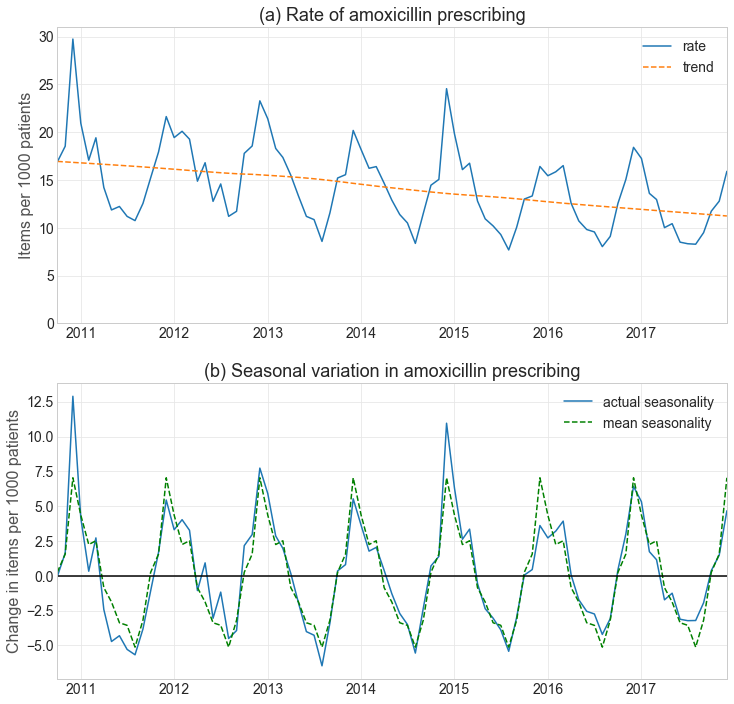

Typical amoxicillin seasonal variation 12.2 per 1000 patients


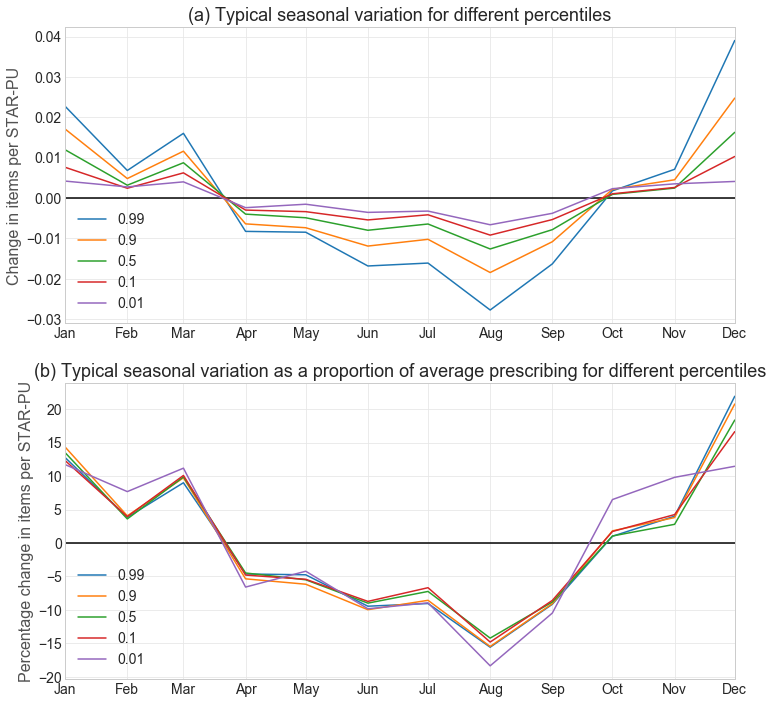

In [410]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]


'''
fig = plt.figure(figsize=(16,35)) 
gs = gridspec.GridSpec(5,1)  # grid layout for subplots

for i in s:
#for decile in [0.01,0.1,0.5,0.9,0.99]:
    ax = plt.subplot(gs[i[2], i[3]])
    data = dfp.loc[(round(dfp['percentile'],2)==i[4])]
    #data.info()
    # for smoothing, dataframe needs to be non-missing and have a DateTime index
    #data = data.dropna()
    data = data.set_index('month')


    calc = decompose(data[i[1]], period=12, lo_frac=0.6, lo_delta=0.0)
    #calc.plot()
    #plt.show()

    average = data.items_per_starpu.sum()/ (len(data.items_per_starpu))
    calc.seasonal = (calc.seasonal/average)*100
    flat = ((data.items_per_starpu-calc.trend)/data.items_per_starpu)*100
    #if decile == .5:
    #    ax.plot(data["dates"],res,'b-',linewidth=2)


    ax.plot(flat,label='actual seasonality')
    ax.plot(calc.seasonal,label='mean seasonality')
    ax.set_ylabel('Percentage change', size =16, alpha=0.8)
    ax.set_title('Percentile: %s'%(i[4]),size = 18)
    ax.tick_params(labelsize=14)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
    ax.set_ylim([-30,30])
    ax.legend(prop={'size': 14})


plt.show()'''
fig = plt.figure(figsize=(12,12)) 
gs = gridspec.GridSpec(2,1)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
#data = data.dropna()
data = all_antibiotics.loc[all_antibiotics["month"]>"2010-09-01"]
data = data.groupby('month').sum()[['items','list_size']]
data = pd.DataFrame(data['items']/(data.list_size/1000))

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
#calc.seasonal = (calc.seasonal/average)*100
flat = ((data-calc.trend))#/data)*100

ax = plt.subplot(gs[0,0])
ax.plot(data,label='rate')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(a) Rate of total prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,72])
ax.legend(prop={'size': 14})

ax = plt.subplot(gs[1,0])
ax.plot(flat,label='actual seasonality')
ax.plot(calc.seasonal,'g--',label='mean seasonality')
ax.axhline(0,color='black')
ax.set_ylabel('Change in items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(b) Seasonal variation in total prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
#ax.set_ylim([0,0.035])
ax.legend(prop={'size': 14})
plt.savefig('seasonal_variation_total.png', format='png', dpi=300,bbox_inches='tight')
plt.show()


fig = plt.figure(figsize=(12,12)) 
gs = gridspec.GridSpec(2,1)  # grid layout for subplots


# for smoothing, dataframe needs to be non-missing and have a DateTime index
#data = data.dropna()
data = all_antibiotics.loc[all_antibiotics["month"]>"2010-09-01"]
data = data.groupby('month').sum()[['amoxicillin','list_size']]
data = pd.DataFrame(data.amoxicillin/(data.list_size/1000))

calc = decompose(data, period=12, lo_frac=0.6, lo_delta=0.0)
average = data.sum()/ (len(data))
#calc.seasonal = (calc.seasonal/average)*100
flat = ((data-calc.trend))#/data)*100

ax = plt.subplot(gs[0,0])
ax.plot(data,label='rate')
ax.plot(calc.trend,'--',label='trend')
ax.set_ylabel('Items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(a) Rate of amoxicillin prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
ax.set_ylim([0,31])
ax.legend(prop={'size': 14})

ax = plt.subplot(gs[1,0])
ax.plot(flat,label='actual seasonality')
ax.plot(calc.seasonal,'g--',label='mean seasonality')
ax.axhline(0,color='black')
ax.set_ylabel('Change in items per 1000 patients', size =16, alpha=0.8)
ax.set_title('(b) Seasonal variation in amoxicillin prescribing',size = 18)
ax.tick_params(labelsize=14)
ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
#ax.set_ylim([0,0.035])
ax.legend(prop={'size': 14})
plt.show()
print("Typical amoxicillin seasonal variation %s per 1000 patients"%(round(calc.seasonal[0].max()-calc.seasonal[0].min(),1)))

s = [(0,'items_per_starpu',0,0,0.99),
     (1,'items_per_starpu',1,0,0.9),
     (2,'items_per_starpu',2,0,0.5),
     (3,'items_per_starpu',3,0,0.1),
     (4,'items_per_starpu',4,0,0.01)]
fig = plt.figure(figsize=(12,12)) 
gs = gridspec.GridSpec(2,1)  # grid layout for subplots
ax = plt.subplot(gs[0,0])
ax.axhline(0,color='black')
ax2 = plt.subplot(gs[1,0])
ax2.axhline(0,color='black')
for i in s:
    data = dfp.loc[(round(dfp['percentile'],2)==i[4])]
    # for smoothing, dataframe needs to be non-missing and have a DateTime index
    #data = data.dropna()
    data = data.set_index('month')
    calc = decompose(data[i[1]], period=12, lo_frac=0.6, lo_delta=0.0)
    august = pd.DataFrame(data.items_per_starpu.reset_index().loc[pd.DatetimeIndex(data.reset_index()['month']).month==8])
    average = august.sum() / (len(august))
    average = data.items_per_starpu.sum()/ (len(data.items_per_starpu))
    minimum = calc.seasonal.min()
    
    ax.plot(calc.seasonal,label=i[4])
    ax.set_ylabel('Change in items per STAR-PU', size =16, alpha=0.8)
    ax.set_title('(a) Typical seasonal variation for different percentiles',size = 18)
    ax.tick_params(labelsize=14)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
    #ax.set_ylim([-20,25])
    ax.legend(prop={'size': 14})
    ax.set_xlim(['2017-01-01', dfp['dates'].max()]) # set x axis range as full date range
    bins = np.arange(1,14)
    ax.set_xticklabels([datetime.date(1900,i,1).strftime('%b') for i in bins[:-1]])
    
    calc.seasonal = (calc.seasonal / average) * 100
    
    ax2.plot(calc.seasonal,label=i[4])
    ax2.set_ylabel('Percentage change in items per STAR-PU', size =16, alpha=0.8)
    ax2.set_title('(b) Typical seasonal variation as a proportion of average prescribing for different percentiles',size = 18)
    ax2.tick_params(labelsize=14)
    ax2.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range
    #ax2.set_ylim([-20,25])
    ax2.legend(prop={'size': 14})
    ax2.set_xlim(['2017-01-01', dfp['dates'].max()]) # set x axis range as full date range
    bins = np.arange(1,14)
    ax2.set_xticklabels([datetime.date(1900,i,1).strftime('%b') for i in bins[:-1]])
plt.show()

# Additional plots for appendices

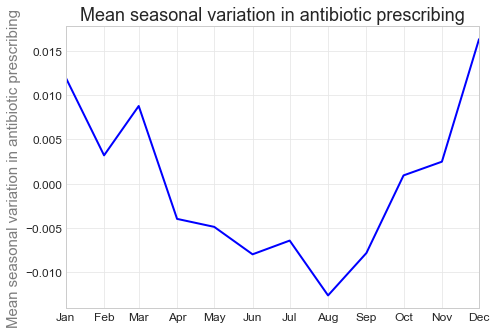

In [406]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]
#import calendar
#dfp['Month'] = pd.DatetimeIndex(dfp['month']).month
#dfp['Month'] = dfp['Month'].apply(lambda x: calendar.month_abbr[x])

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'items_per_starpu',0,0,'Mean seasonal variation in antibiotic prescribing')]
x = pd.Series(x)

fig = plt.figure(figsize=(16,35)) 
gs = gridspec.GridSpec(6,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in [0.5]:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        #data.info()
        # for smoothing, dataframe needs to be non-missing and have a DateTime index
        #data = data.dropna()
        data = data.set_index('month')
        res = data[[i[1]]]
        #res = seasonal_decompose(res, model='additive') # cruder smoothing
        res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        res = res.seasonal
        
        if decile == .5:
            ax.plot(data["dates"],res,'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],res,'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],res,'b--',linewidth=1)
    #if  i[3]%2==0:    # set y axis title only for charts in leftmost column
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    #ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim(['2017-01-01', dfp['dates'].max()]) # set x axis range as full date range
    bins = np.arange(1,14)
    ax.set_xticklabels([datetime.date(1900,i,1).strftime('%b') for i in bins[:-1]] )

plt.subplots_adjust(wspace = 0.16,hspace = 0.15)
plt.savefig('seasonal_variation.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

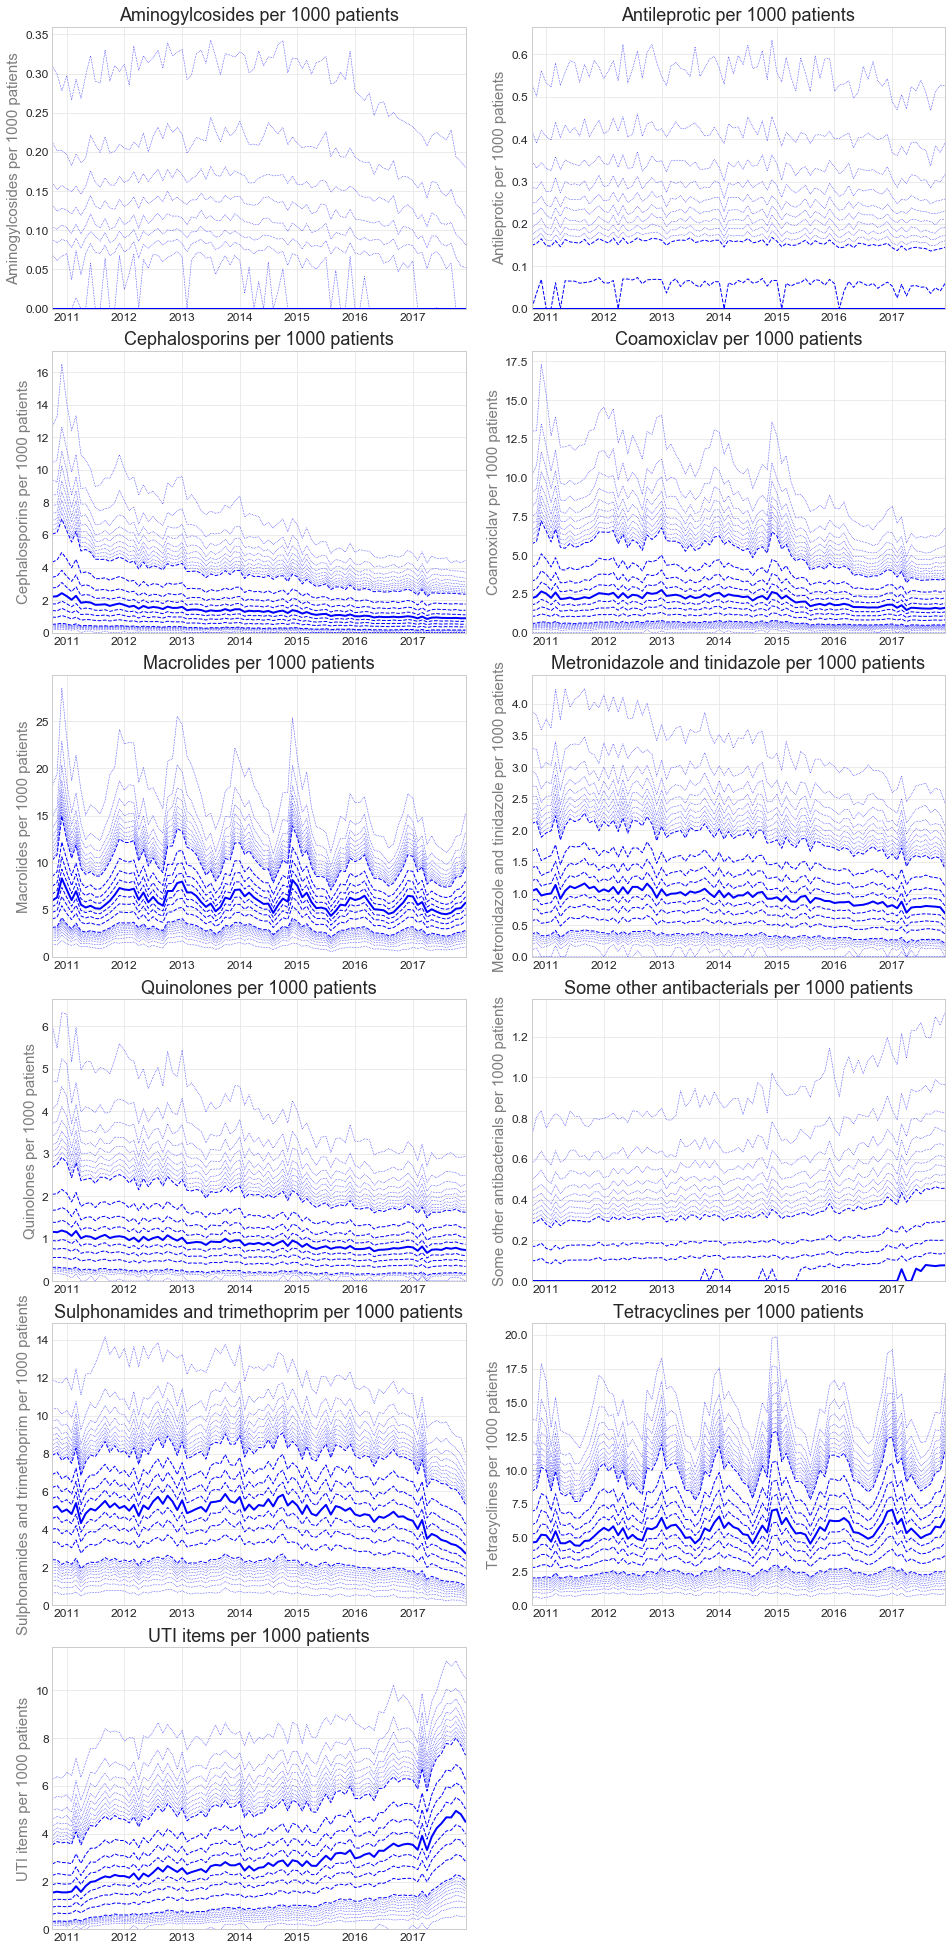

In [407]:
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.sort_values(by=["month"])#,"drug"])
dfp['month_str'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month_str']]

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,'aminogylcosides_per_thousand',0,0,'Aminogylcosides per 1000 patients'), 
     (1,'antileprotic_per_thousand',0,1,'Antileprotic per 1000 patients'),
     (2,'cephalosporins_per_thousand',1,0,'Cephalosporins per 1000 patients'),
     (3,'coamoxiclav_per_thousand',1,1, 'Coamoxiclav per 1000 patients'),
     (4,'macrolides_per_thousand',2,0, 'Macrolides per 1000 patients'),
     (5,'metroni_tini_ornidazole_per_thousand',2,1, 'Metronidazole and tinidazole per 1000 patients'),
     (6,'quinolones_per_thousand',3,0, 'Quinolones per 1000 patients'),
     (7,'some_other_antibacterials_per_thousand',3,1, 'Some other antibacterials per 1000 patients'),
     (8,'sulphonamides_trimethoprim_per_thousand',4,0, 'Sulphonamides and trimethoprim per 1000 patients'),
     (9,'tetracyclines_per_thousand',4,1, 'Tetracyclines per 1000 patients'),
     (10,'uti_items_per_thousand',5,0, 'UTI items per 1000 patients')
    ]
x = pd.Series(x)

fig = plt.figure(figsize=(16,35)) 
gs = gridspec.GridSpec(6,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        #data.info()
        # for smoothing, dataframe needs to be non-missing and have a DateTime index
        #data = data.dropna()
        data = data.set_index('month')
        res = data[[i[1]]]
        #res = seasonal_decompose(res, model='additive') # cruder smoothing
        #res = decompose(res, period=12, lo_frac=0.6, lo_delta=0.0)
        #res = res.trend
        
        if decile == .5:
            ax.plot(data["dates"],res,'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],res,'b:',linewidth=0.6)
        else:
            #print (data)
            ax.plot(data["dates"],res,'b--',linewidth=1)
    #if  i[3]%2==0:    # set y axis title only for charts in leftmost column
    ax.set_ylabel(i[4], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.16,hspace = 0.15)
plt.savefig('practice_deciles_appendices.png', format='png', dpi=300,bbox_inches='tight')
plt.show()